In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('factor_pass9.csv', index_col=0)
data['continuous_count'] = data.groupby((data['evebit'] != data['evebit'].shift(1)).cumsum()).cumcount() + 1
data = data.reindex(columns=data.columns.tolist()[:-2] + ['continuous_count', 'return'])
data.dropna(inplace=True)

insample_data = data.loc[data.loc[:, 'date'] < "2022-01-01", :]
other_info_insample = insample_data.iloc[:, :3]
insample_data_sorted = insample_data.sort_values('date')
insample_data_sorted['rank'] = insample_data_sorted['date'].rank()
sum_of_weight = (insample_data_sorted['rank']).sum()
insample_data_sorted['weight'] = insample_data_sorted['rank'] / sum_of_weight
outdsample_data = data.loc[data.loc[:, 'date'] >= "2022-01-01", :]

X = insample_data_sorted.iloc[:, 3:-3]
y = insample_data_sorted.iloc[:, -3]
other_info_outsample_test = outdsample_data.iloc[:, :3]
X_outsample_test = outdsample_data.iloc[:, 3:-1]
y_outsample_test = outdsample_data.iloc[:, -1]

In [4]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

X_scaled = scaler_X.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

X_outsample_test_scaled = scaler_X.transform(X_outsample_test)

In [5]:
y_info = pd.concat([other_info_insample, y], axis=1)
y_info

,id,name,date,return
20,338,潍柴动力,2016-02-01,0.016925
21,338,潍柴动力,2016-02-02,-0.008322
22,338,潍柴动力,2016-02-03,0.012587
23,338,潍柴动力,2016-02-04,-0.008287
24,338,潍柴动力,2016-02-05,-0.012535
...,...,...,...,...
16732,601689,拓普集团,2021-12-27,-0.006483
16733,601689,拓普集团,2021-12-28,-0.013609
16734,601689,拓普集团,2021-12-29,0.020601
16735,601689,拓普集团,2021-12-30,-0.018519


In [6]:
def cal_weight(df):
    df.loc[:, "return"] = df.loc[:, "return"] - df.loc[:, "return"].min()
    df.loc[:, "weight"] = df.loc[:, "return"]/df.loc[:, "return"].sum() if df.loc[:, "return"].sum() != 0 else 1/8
    return df

y = y_info.groupby('date').apply(cal_weight)["weight"]

In [47]:
# NN
tf.random.set_seed(42)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
sample_weights = insample_data_sorted['weight'].loc[X_train.index]

# 创建一个 Sequential 模型
model = Sequential()

model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss="mse")

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], sample_weight=sample_weights)

Epoch 1/100
340/340 [==============================] - 1s 1ms/step - loss: 9.3287e-06 - val_loss: 0.0438
Epoch 2/100
340/340 [==============================] - 0s 965us/step - loss: 2.5643e-06 - val_loss: 0.0126
Epoch 3/100
340/340 [==============================] - 0s 1ms/step - loss: 1.1377e-06 - val_loss: 0.0089
Epoch 4/100
340/340 [==============================] - 0s 997us/step - loss: 9.4772e-07 - val_loss: 0.0085
Epoch 5/100
340/340 [==============================] - 0s 1ms/step - loss: 8.8742e-07 - val_loss: 0.0084
Epoch 6/100
340/340 [==============================] - 0s 981us/step - loss: 8.2777e-07 - val_loss: 0.0083
Epoch 7/100
340/340 [==============================] - 0s 990us/step - loss: 8.1292e-07 - val_loss: 0.0082
Epoch 8/100
340/340 [==============================] - 0s 975us/step - loss: 7.8275e-07 - val_loss: 0.0082
Epoch 9/100
340/340 [==============================] - 0s 972us/step - loss: 7.6557e-07 - val_loss: 0.0081
Epoch 10/100
340/340 [=====================

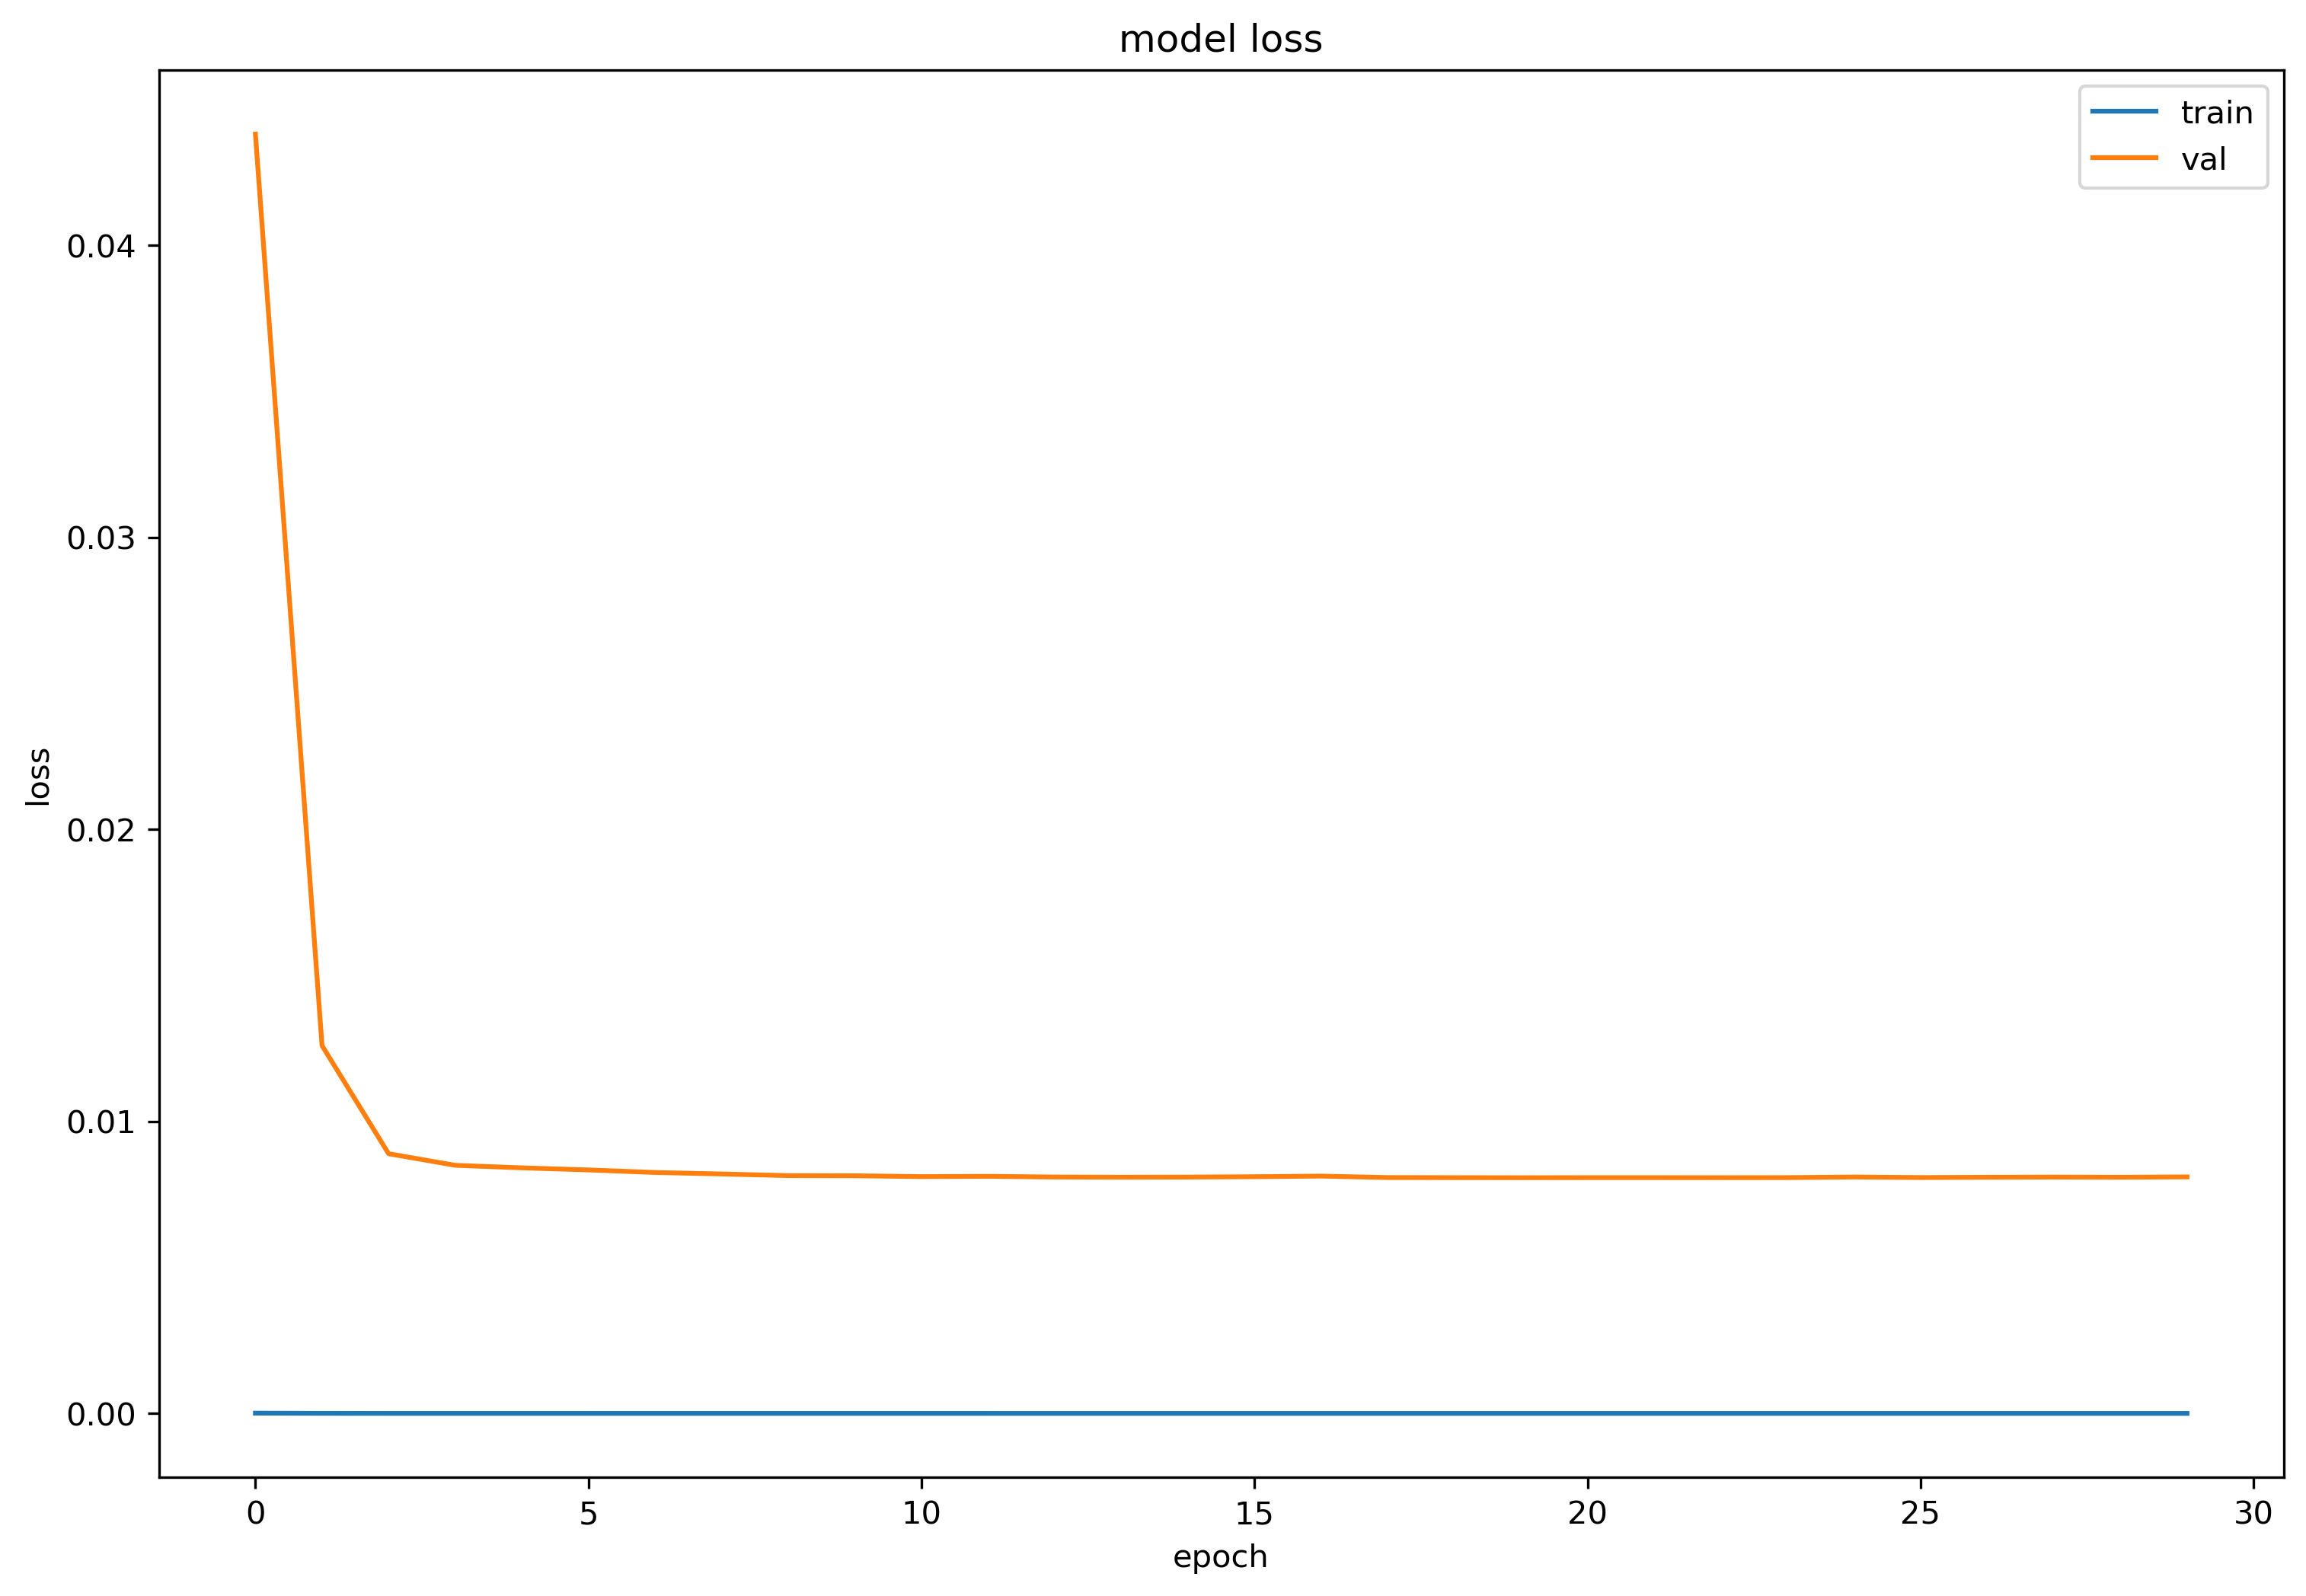

In [48]:
# plot history
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [36]:
def cal_ICIR(data: pd.DataFrame, feild: str) -> tuple[float, float]:
    """
    data is a dataframe with columns: date, return, factor feild
    feild is the factor name
    return IC and IR
    """
    data = data.loc[:, ['date', 'weight', feild]]
    data.dropna(inplace=True)
    IC_dataframe = data.groupby('date').apply(lambda x: x.corr(method='spearman')[feild]['weight'])
    return IC_dataframe.mean(), IC_dataframe.mean()/IC_dataframe.std()

def test_factor(ICIR: tuple[float, float]) -> str:
    """
    ICIR is a tuple of IC and IR
    return the test result
    """
    if abs(ICIR[0]) > 0.01 and abs(ICIR[1]) > 0.03:
        return 'pass'
    else:
        return 'fail'

In [37]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 16)                464       
                                                                 
 dropout_23 (Dropout)        (None, 16)                0         
                                                                 
 batch_normalization_23 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 8)                 136       
                                                                 
 dropout_24 (Dropout)        (None, 8)                 0         
                                                                 
 batch_normalization_24 (Bat  (None, 8)                32        
 chNormalization)                                     

In [43]:
y_info_out = pd.concat([other_info_outsample_test, y_outsample_test], axis=1)
y_outsample_test_weight = y_info_out.groupby('date').apply(cal_weight)["weight"]

In [49]:
y_pred = model.predict(X_outsample_test_scaled)
matrix = pd.concat([other_info_outsample_test, pd.DataFrame(y_pred, columns=['preds'], index = X_outsample_test.index), y_outsample_test_weight], axis=1)
ICIR = cal_ICIR(matrix, "preds")
print(ICIR)
result = test_factor(ICIR)

68/68 [==============================] - 0s 567us/step
(0.03184387368037693, 0.08366613832044148)


In [51]:
matrix.to_csv('./result/NN.csv')

In [50]:
model.save('./model/NN')

INFO:tensorflow:Assets written to: ./model/NN\assets


## CNN

In [7]:
X_scaled.sort_index(inplace=True)

In [8]:
X_scaled["name"] = insample_data.loc[X_scaled.index, "name"]
X_scaled

,evebit,dividendyield,day_momentum,val_ortoev_ttm,val_lnmv,val_lntotassets,fa_sellexpensetogr_ttm,fa_salestocost_ttm,mmt_discret_w,vol_up_std_m,...,fa_octogr_ttm,fa_netprofitmargin_ttm,fa_salescashtoor,fa_cashrecovratio_ttm,fa_blev,fa_current,fa_apturn_ttm,fa_ncgr_ttm,continuous_count,name
20,-0.224035,1.418080,-2.082127,1.081771,-0.910296,0.212205,1.565639,-0.440860,-1.428041,-0.656751,...,-0.015415,-0.684987,-0.127029,0.620025,1.660471,0.558749,-0.737744,-0.157306,-0.667580,潍柴动力
21,-0.224035,1.370849,-1.710067,1.086433,-0.894614,0.212205,1.565639,-0.440860,-0.483166,-0.722259,...,-0.015415,-0.684987,-0.127029,0.620025,1.660471,0.558749,-0.737744,-0.157306,-0.660905,潍柴动力
22,-0.224035,1.394266,-1.647428,1.126117,-0.902455,0.212205,1.565639,-0.440860,-0.483166,-0.921173,...,-0.015415,-0.684987,-0.127029,0.620025,1.660471,0.558749,-0.737744,-0.157306,-0.654230,潍柴动力
23,-0.224035,1.359285,-1.368342,1.087840,-0.890787,0.212205,1.565639,-0.440860,0.461709,-0.958774,...,-0.015415,-0.684987,-0.127029,0.620025,1.660471,0.558749,-0.737744,-0.157306,-0.647555,潍柴动力
24,-0.224035,1.382509,-1.353152,1.096549,-0.898535,0.212205,1.565639,-0.440860,-0.483166,-1.154851,...,-0.015415,-0.684987,-0.127029,0.620025,1.660471,0.558749,-0.737744,-0.157306,-0.640880,潍柴动力
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16732,-0.026824,-1.123766,-0.141756,-0.978425,-0.218361,-1.623498,-2.863388,-0.117912,1.406585,1.869780,...,-0.809397,0.446140,0.291438,0.372898,-0.897316,0.858880,-0.951942,0.191049,-0.420600,拓普集团
16733,-0.026824,-1.121834,-0.048841,-0.977664,-0.224428,-1.623498,-2.863388,-0.117912,0.461709,1.957965,...,-0.809397,0.446140,0.291438,0.372898,-0.897316,0.858880,-0.951942,0.191049,-0.413925,拓普集团
16734,-0.026824,-1.117723,-0.066233,-0.976045,-0.237216,-1.623498,-2.863388,-0.117912,-0.483166,1.957965,...,-0.809397,0.446140,0.291438,0.372898,-0.897316,0.858880,-0.951942,0.191049,-0.407250,拓普集团
16735,-0.026824,-1.123820,0.386992,-0.978446,-0.218174,-1.623498,-2.863388,-0.117912,-0.483166,1.726418,...,-0.809397,0.446140,0.291438,0.372898,-0.897316,0.858880,-0.951942,0.191049,-0.400575,拓普集团


In [9]:
import pandas as pd
import numpy as np
from PIL import Image

# 假设你的数据存储在一个名为df的DataFrame中
# df是一个包含数据的Pandas DataFrame

# 获取所有不同的名称
unique_names = X_scaled['name'].unique()

# 遍历不同的名称，处理数据并保存成图像
for name in unique_names:
    # 获取特定名称的数据
    name_data = X_scaled[X_scaled['name'] == name].iloc[:, :-1]  # 假设最后一列是名称列
    
    # 将数据标准化到0-255的范围（假设数据已经在一定范围内)
    name_data_normalized = ((name_data - name_data.min()) / (name_data.max() - name_data.min())) * 255
    name_data_normalized = name_data_normalized.replace(np.nan, 0)
    name_data_normalized = name_data_normalized.astype(np.uint8)
    
    # 转换成31x31的图像
    num_samples = name_data_normalized.shape[0]
    for i in range(num_samples - 27):
        # 将数据变换成27x27的图像
        img_data = name_data_normalized.iloc[i:i+27, :-1].values.reshape(27, 27)
        img = Image.fromarray(img_data)
        
        # 保存图像，可以根据需要修改保存路径和文件名
        img.save(f"./image/27.png", dpi = (30000, 30000))
        break
    break

In [10]:
X_scaled.insert(loc=1, column='continuous_count_b1', value=X_scaled['continuous_count'])
X_scaled.insert(loc=8, column='continuous_count_b2', value=X_scaled['continuous_count'])
X_scaled.insert(loc=10, column='continuous_count_b3', value=X_scaled['continuous_count'])
X_scaled.insert(loc=12, column='continuous_count_b4', value=X_scaled['continuous_count'])
X_scaled.insert(loc=17, column='continuous_count_b5', value=X_scaled['continuous_count'])
X_scaled.insert(loc=20, column='continuous_count_b6', value=X_scaled['continuous_count'])
X_scaled.insert(loc=23, column='continuous_count_b7', value=X_scaled['continuous_count'])
X_scaled.insert(loc=25, column='continuous_count_b8', value=X_scaled['continuous_count'])
X_scaled.insert(loc=27, column='continuous_count_b9', value=X_scaled['continuous_count'])
X_scaled.insert(loc=29, column='continuous_count_b10', value=X_scaled['continuous_count'])
X_scaled.insert(loc=31, column='continuous_count_b11', value=X_scaled['continuous_count'])
X_scaled.insert(loc=33, column='continuous_count_b12', value=X_scaled['continuous_count'])
X_scaled.insert(loc=35, column='continuous_count_b13', value=X_scaled['continuous_count'])
X_scaled.insert(loc=37, column='continuous_count_b14', value=X_scaled['continuous_count'])
X_scaled.insert(loc=39, column='continuous_count_b15', value=X_scaled['continuous_count'])
X_scaled.insert(loc=41, column='continuous_count_b16', value=X_scaled['continuous_count'])

In [11]:
X_scaled = X_scaled.drop(columns=['continuous_count'])

In [12]:
X_scaled

,evebit,continuous_count_b1,dividendyield,day_momentum,val_ortoev_ttm,val_lnmv,val_lntotassets,fa_sellexpensetogr_ttm,continuous_count_b2,fa_salestocost_ttm,...,fa_cashrecovratio_ttm,continuous_count_b13,fa_blev,continuous_count_b14,fa_current,continuous_count_b15,fa_apturn_ttm,continuous_count_b16,fa_ncgr_ttm,name
20,-0.224035,-0.667580,1.418080,-2.082127,1.081771,-0.910296,0.212205,1.565639,-0.667580,-0.440860,...,0.620025,-0.667580,1.660471,-0.667580,0.558749,-0.667580,-0.737744,-0.667580,-0.157306,潍柴动力
21,-0.224035,-0.660905,1.370849,-1.710067,1.086433,-0.894614,0.212205,1.565639,-0.660905,-0.440860,...,0.620025,-0.660905,1.660471,-0.660905,0.558749,-0.660905,-0.737744,-0.660905,-0.157306,潍柴动力
22,-0.224035,-0.654230,1.394266,-1.647428,1.126117,-0.902455,0.212205,1.565639,-0.654230,-0.440860,...,0.620025,-0.654230,1.660471,-0.654230,0.558749,-0.654230,-0.737744,-0.654230,-0.157306,潍柴动力
23,-0.224035,-0.647555,1.359285,-1.368342,1.087840,-0.890787,0.212205,1.565639,-0.647555,-0.440860,...,0.620025,-0.647555,1.660471,-0.647555,0.558749,-0.647555,-0.737744,-0.647555,-0.157306,潍柴动力
24,-0.224035,-0.640880,1.382509,-1.353152,1.096549,-0.898535,0.212205,1.565639,-0.640880,-0.440860,...,0.620025,-0.640880,1.660471,-0.640880,0.558749,-0.640880,-0.737744,-0.640880,-0.157306,潍柴动力
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16732,-0.026824,-0.420600,-1.123766,-0.141756,-0.978425,-0.218361,-1.623498,-2.863388,-0.420600,-0.117912,...,0.372898,-0.420600,-0.897316,-0.420600,0.858880,-0.420600,-0.951942,-0.420600,0.191049,拓普集团
16733,-0.026824,-0.413925,-1.121834,-0.048841,-0.977664,-0.224428,-1.623498,-2.863388,-0.413925,-0.117912,...,0.372898,-0.413925,-0.897316,-0.413925,0.858880,-0.413925,-0.951942,-0.413925,0.191049,拓普集团
16734,-0.026824,-0.407250,-1.117723,-0.066233,-0.976045,-0.237216,-1.623498,-2.863388,-0.407250,-0.117912,...,0.372898,-0.407250,-0.897316,-0.407250,0.858880,-0.407250,-0.951942,-0.407250,0.191049,拓普集团
16735,-0.026824,-0.400575,-1.123820,0.386992,-0.978446,-0.218174,-1.623498,-2.863388,-0.400575,-0.117912,...,0.372898,-0.400575,-0.897316,-0.400575,0.858880,-0.400575,-0.951942,-0.400575,0.191049,拓普集团


In [13]:
image_array = []
y_image = []
weight_array = []
y.sort_index(inplace=True)
unique_names = X_scaled['name'].unique()

for name in unique_names:
    weight = 0
    name_data = X_scaled[X_scaled['name'] == name].iloc[:, :-1]  # 假设最后一列是名称列
    
    num_samples = name_data.shape[0]
    for i in range(num_samples - 42):
        img_data = name_data.iloc[i:i+43].values.reshape(43, 43)
        image_array.append(img_data)
        y_image.append(y.loc[name_data.index[i+42]])
        weight += 0.5
        weight_array.append(weight)
    
image_array = np.array(image_array)
y_image = pd.DataFrame(y_image, columns=['return'])
weight_array = np.array(weight_array)

In [14]:
for name in unique_names:
    # 获取特定名称的数据
    name_data = X_scaled[X_scaled['name'] == name].iloc[:, :-1]  # 假设最后一列是名称列
    
    # 将数据标准化到0-255的范围（假设数据已经在一定范围内)
    name_data_normalized = ((name_data - name_data.min()) / (name_data.max() - name_data.min())) * 255
    name_data_normalized = name_data_normalized.replace(np.nan, 0)
    name_data_normalized = name_data_normalized.astype(np.uint8)
    
    # 转换成43x43的图像
    num_samples = name_data_normalized.shape[0]
    for i in range(num_samples - 42):
        # 将数据变换成43x43的图像
        img_data = name_data_normalized.iloc[i:i+43, :].values.reshape(43, 43)
        img = Image.fromarray(img_data)
        
        # 保存图像，可以根据需要修改保存路径和文件名
        img.save(f"./image/43.png", dpi = (30000, 30000))
        break
    break

In [15]:
image_array.shape

(11646, 43, 43)

In [38]:
tf.random.set_seed(42)

input_shape = (43, 43, 1) 

# split the data into train and val
X_train, X_val, y_train, y_val = train_test_split(image_array, y_image, test_size=0.1, random_state=42)
sample_weights = weight_array[y_train.index]

model = Sequential()

leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.001)

model.add(Conv2D(64, kernel_size=(6, 6), input_shape=input_shape))
model.add(Dropout(0.1))
model.add(leaky_relu)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Conv2D(32, kernel_size=(4, 4)))
model.add(Dropout(0.1))
model.add(leaky_relu)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(32))
model.add(leaky_relu)
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(16))
model.add(leaky_relu)
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

print(model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], sample_weight=sample_weights)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 38, 38, 64)        2368      
                                                                 
 dropout_8 (Dropout)         (None, 38, 38, 64)        0         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   multiple                  0         
                                                                 
 batch_normalization_8 (Batc  (None, 38, 38, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 9, 9, 64)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 32)         

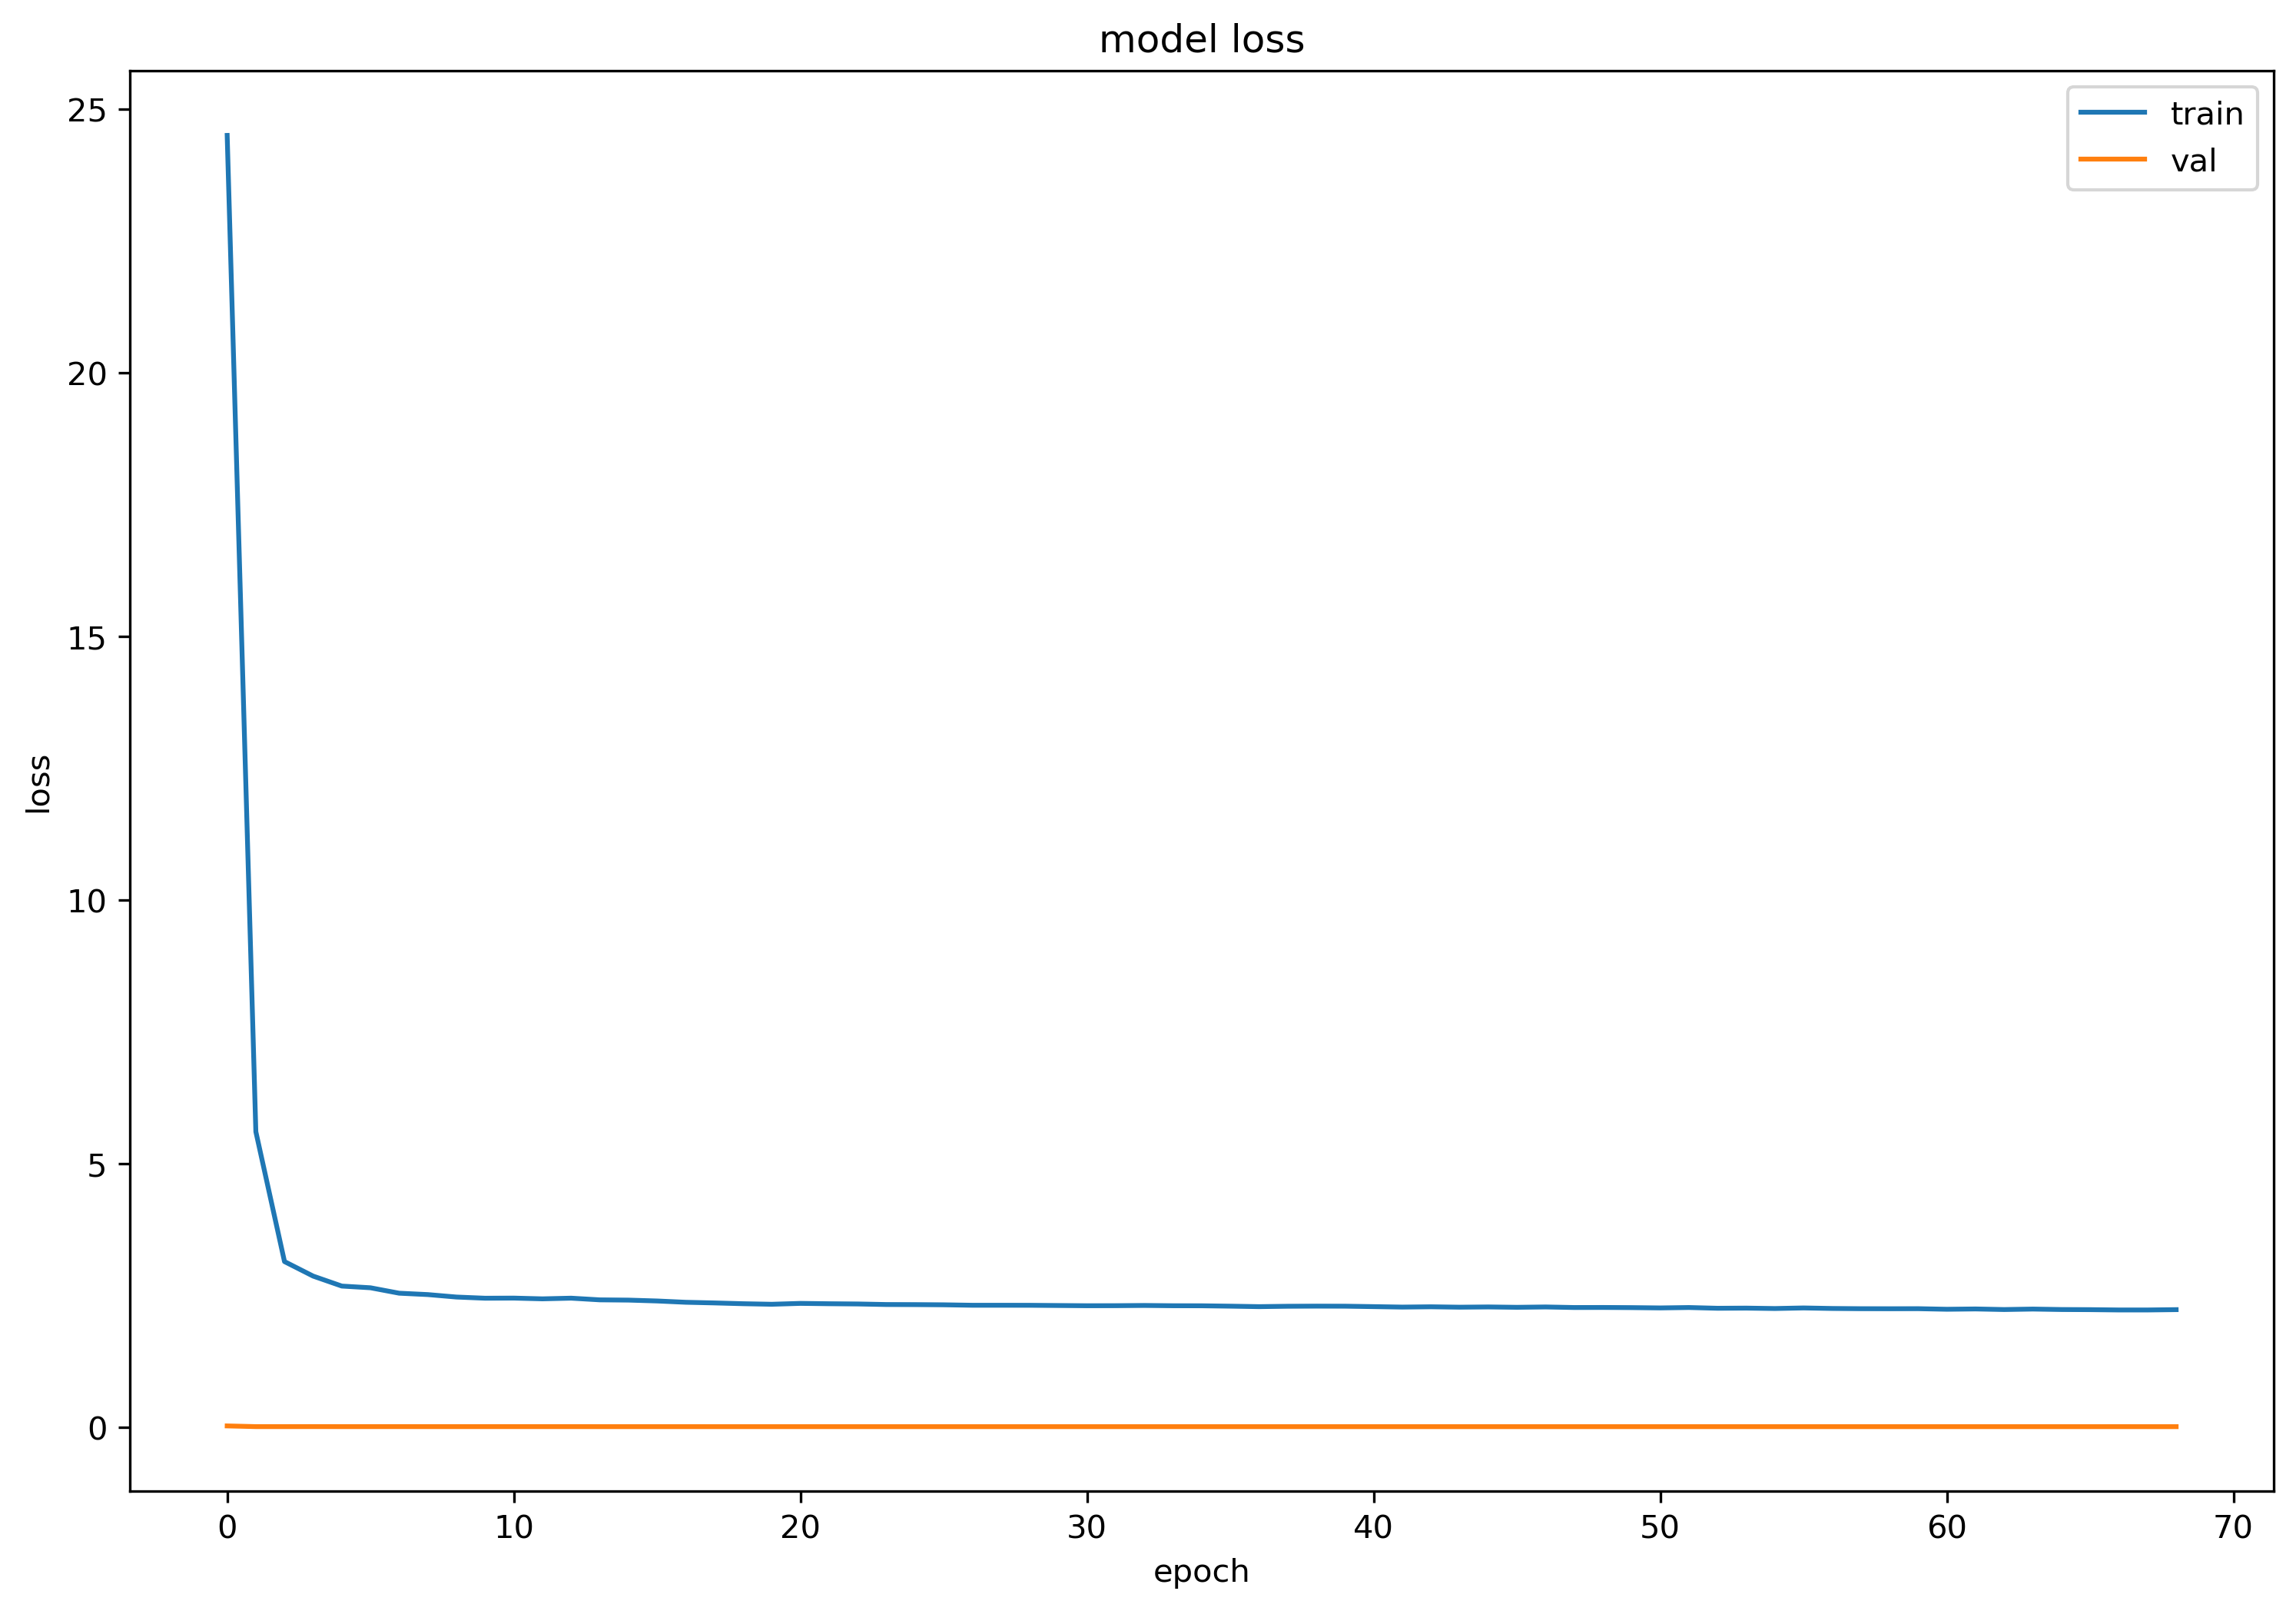

In [39]:
# plot history
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [29]:
X_outsample_test = data.loc[data.loc[:, 'date'] >= "2021-01-01"].iloc[:, 3:-1]
y_outsample_test = data.loc[data.loc[:, 'date'] >= "2021-01-01"].iloc[:, -1]
other_info_outsample_test = data.loc[data.loc[:, 'date'] >= "2021-01-01"].iloc[:, :3]

X_outsample_test_scaled = scaler_X.transform(X_outsample_test)
X_outsample_test_scaled = pd.DataFrame(X_outsample_test_scaled, index=X_outsample_test.index, columns=X_outsample_test.columns)

In [30]:
y_other_info = pd.concat([other_info_outsample_test, y_outsample_test], axis=1)
y_outsample_test_weight = y_other_info.groupby('date').apply(cal_weight)["weight"]

y_outsample_test_weight

1216     0.152670
1217     0.096163
1218     0.099557
1219     0.057349
1220     0.084889
           ...   
16973    0.281990
16974    0.046954
16975    0.000000
16976    0.137572
16977    0.094412
Name: weight, Length: 4451, dtype: float64

In [31]:
X_outsample_test_scaled.sort_index(inplace=True)
X_outsample_test_scaled["name"] = data.loc[X_outsample_test_scaled.index, "name"]
X_outsample_test_scaled

,evebit,dividendyield,day_momentum,val_ortoev_ttm,val_lnmv,val_lntotassets,fa_sellexpensetogr_ttm,fa_salestocost_ttm,mmt_discret_w,vol_up_std_m,...,fa_octogr_ttm,fa_netprofitmargin_ttm,fa_salescashtoor,fa_cashrecovratio_ttm,fa_blev,fa_current,fa_apturn_ttm,fa_ncgr_ttm,continuous_count,name
1216,-0.189350,-0.098002,-0.025160,0.177821,0.490094,0.945416,0.289429,-0.116637,0.461709,-0.860627,...,-0.271264,-0.270663,-0.998642,0.334266,2.104604,-0.398789,-0.830028,-0.150266,-0.794408,潍柴动力
1217,-0.189350,-0.133335,0.413945,0.149903,0.515391,0.945416,0.289429,-0.116637,0.461709,-0.766867,...,-0.271264,-0.270663,-0.998642,0.334266,2.104604,-0.398789,-0.830028,-0.150266,-0.787733,潍柴动力
1218,-0.189350,-0.119111,0.251696,0.165455,0.505121,0.945416,0.289429,-0.116637,0.461709,-0.766867,...,-0.271264,-0.270663,-0.998642,0.334266,2.104604,-0.398789,-0.830028,-0.150266,-0.781058,潍柴动力
1219,-0.189350,-0.148015,0.584130,0.135814,0.526124,0.945416,0.289429,-0.116637,1.406585,-0.781567,...,-0.271264,-0.270663,-0.998642,0.334266,2.104604,-0.398789,-0.830028,-0.150266,-0.774383,潍柴动力
1220,-0.189350,-0.151823,0.602186,0.112740,0.528924,0.945416,0.289429,-0.116637,1.406585,-0.746932,...,-0.271264,-0.270663,-0.998642,0.334266,2.104604,-0.398789,-0.830028,-0.150266,-0.767708,潍柴动力
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16973,0.051204,-0.956797,-1.534232,-0.940872,-0.159743,-1.218589,-2.159190,-0.253636,-1.428041,-0.043556,...,-0.835576,0.377116,0.290513,0.133992,-0.192765,-0.094012,-0.923178,-0.163161,-0.433951,拓普集团
16974,0.051204,-0.990475,-0.359622,-0.951637,-0.089179,-1.218589,-2.159190,-0.253636,-1.428041,1.027231,...,-0.835576,0.377116,0.290513,0.133992,-0.192765,-0.094012,-0.923178,-0.163161,-0.427275,拓普集团
16975,0.051204,-0.989920,-0.349947,-0.951459,-0.090390,-1.218589,-2.159190,-0.253636,-1.428041,1.027231,...,-0.835576,0.377116,0.290513,0.133992,-0.192765,-0.094012,-0.923178,-0.163161,-0.420600,拓普集团
16976,0.051204,-0.962523,-1.157410,-0.942698,-0.148075,-1.218589,-2.159190,-0.253636,-1.428041,1.075637,...,-0.835576,0.377116,0.290513,0.133992,-0.192765,-0.094012,-0.923178,-0.163161,-0.413925,拓普集团


In [32]:
X_outsample_test_scaled.insert(loc=1, column='continuous_count_b1', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=8, column='continuous_count_b2', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=10, column='continuous_count_b3', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=12, column='continuous_count_b4', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=17, column='continuous_count_b5', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=20, column='continuous_count_b6', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=23, column='continuous_count_b7', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=25, column='continuous_count_b8', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=27, column='continuous_count_b9', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=29, column='continuous_count_b10', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=31, column='continuous_count_b11', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=33, column='continuous_count_b12', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=35, column='continuous_count_b13', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=37, column='continuous_count_b14', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=39, column='continuous_count_b15', value=X_outsample_test_scaled['continuous_count'])
X_outsample_test_scaled.insert(loc=41, column='continuous_count_b16', value=X_outsample_test_scaled['continuous_count'])

In [33]:
X_outsample_test_scaled.drop(columns=['continuous_count'], inplace=True)

In [44]:
image_array_test = []
y_image_test = []
y_image_return = []
weight_array_test = []
y_outsample_test.sort_index(inplace=True)
unique_names = X_outsample_test_scaled['name'].unique()
other_info_outsample_test.sort_index(inplace=True)
other_info_test = []

for name in unique_names:
    weight = 0
    name_data = X_outsample_test_scaled[X_outsample_test_scaled['name'] == name].iloc[:, :-1]  # 假设最后一列是名称列
    
    num_samples = name_data.shape[0]
    for i in range(num_samples - 42):
        img_data = name_data.iloc[i:i+43].values.reshape(43, 43)
        image_array_test.append(img_data)
        y_image_test.append(y_outsample_test_weight.loc[name_data.index[i+42]])
        y_image_return.append(y_outsample_test.loc[name_data.index[i+42]])
        other_info_test.append(other_info_outsample_test.loc[name_data.index[i+42]])
        weight += 0.5
        weight_array_test.append(weight)
    
image_array_test = np.array(image_array_test)
y_image_test = pd.DataFrame(y_image_test, columns=['weight'])
y_image_return = pd.DataFrame(y_image_return, columns=['weight'])
other_info_test = pd.DataFrame(other_info_test, columns=other_info_outsample_test.columns)
other_info_test.index = y_image_test.index
weight_array_test = np.array(weight_array_test)

In [45]:
preds = model.predict(image_array_test)
matrix = pd.concat([other_info_test, pd.DataFrame(preds, columns=['preds'], index = y_image_return.index), y_image_return], axis=1)
matrix = matrix.loc[matrix['date'] >= "2022-01-01", :]
ICIR = cal_ICIR(matrix, "preds")
print(ICIR)
result = test_factor(ICIR)
print(result)

126/126 [==============================] - 2s 16ms/step
(0.0040982404524670096, 0.011875473499250274)
fail


In [41]:
matrix.to_csv('./result/CNN.csv')

In [42]:
# store the model
model.save('./model/CNN')

INFO:tensorflow:Assets written to: ./model/CNN\assets


INFO:tensorflow:Assets written to: ./model/CNN\assets
